# Demo3: FWI problem with TV regularization

In this note, we perform the FWI algorithm with TV regularization.
The gradient used here is the l2 gradient projected in a closed ball in BV space.
Then we use the gradient descent method as the optimziation algorithm to solve the FWI problem.

## Background setting

In [1]:
using PyPlot, LinearAlgebra, ImageFiltering, JLD2, MATLAB, MAT

include("code/acoustic_solver.jl")
include("code/acoustic_solver_parallel.jl")
include("code/adjoint_method.jl")
include("code/TV_projection.jl")
include("code/TV_function.jl")
include("code/optimization.jl");

In [2]:
# load data
file = matopen("marmousi_data/marmousi_vp10.mat")
vp10 = read(file, "marmousi_vp10") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

Nx = 101
Ny = 101
h = 10*1e-3

# c_true = vp10[80:80+Nx-1,750:750+Ny-1]
c_true = vp10[31:31+Nx-1,780:780+Ny-1]

# gaussian filter to generate the initial model
c = imfilter(c_true, Kernel.gaussian(5));
c = (c .- minimum(c)) ./ (maximum(c)-minimum(c)) * (maximum(c_true)-minimum(c_true)) .+ minimum(c_true);
c[1:16, :] .= 1.5

rho = ones(Nx,Ny);

CFL: 0.47383324305216473

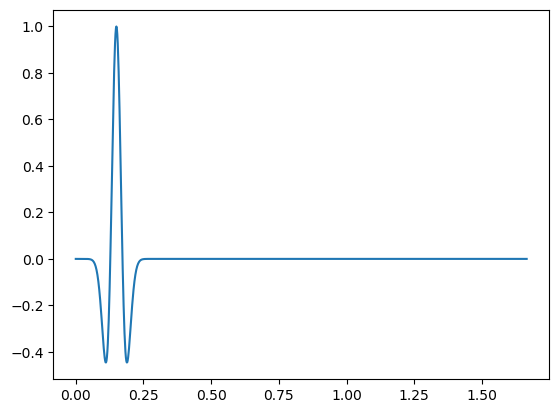

In [3]:
# setup coef
Nt = 1000
Fs = 600
dt = 1 / Fs
t = range(0, step=dt, length=Nt)
println("CFL: ", maximum(c_true) * dt / h);

# source
source = source_ricker(10,0.15,t)
source_num = 6
source_position = zeros(Int,source_num,2)
for i = 1:source_num
    source_position[i,:] = [5 1+20(i-1)]
end
source = repeat(source, 1, 1);

# receiver
receiver_num = 51
receiver_position = zeros(Int,receiver_num,2)
for i = 1:receiver_num
    receiver_position[i,:] = [1, (i-1)*2+1]
end

# PML
pml_len = 30
pml_coef = 50;

plot(t,source);

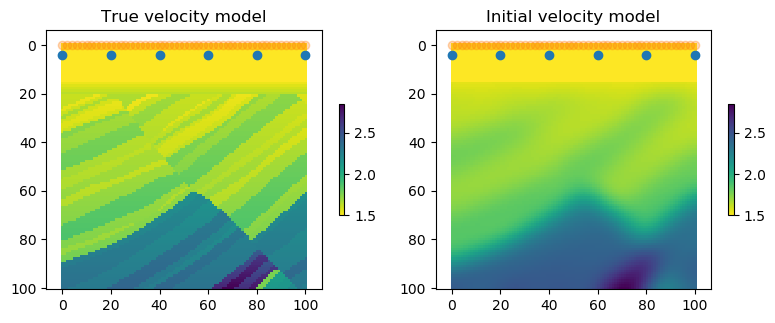

In [4]:
# plot model
figure(figsize=(8,4))

subplot(121)
imshow(c_true, cmap="viridis_r"); title("True velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

subplot(122)
imshow(c, cmap="viridis_r"); title("Initial velocity model"); colorbar(shrink=0.3)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.3)

tight_layout()

In [5]:
# forward modeling
@time wavefield, received_data = multi_solver(c_true, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

# compute the gradient
@time kk, grad_l2_x0 = grad_l2(received_data, c, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

  8.781754 seconds (14.72 M allocations: 1.161 GiB, 7.79% gc time)
 10.009753 seconds (9.00 M allocations: 1.839 GiB, 2.47% gc time)


## Compare the gradient with different lambda
Now we project the gradient to the closed ball in BV space. The lambda controls the radius of the ball.

In [6]:
lambda1 = 1e-13
lambda2 = 1e-12
lambda3 = 1e-11

g = reshape(grad_l2_x0, Nx, Ny);

grad_tv1 = TV_projection(g, lambda1; iterMax=5000);
grad_tv2 = TV_projection(g, lambda2; iterMax=5000);
grad_tv3 = TV_projection(g, lambda3; iterMax=5000);

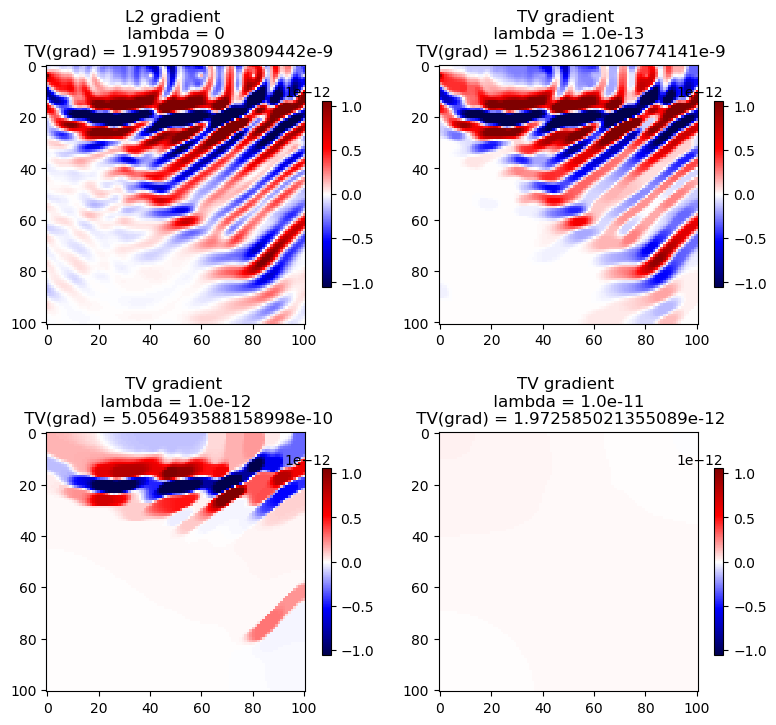

In [7]:
figure(figsize=(8,7.5))

val = 0.3*maximum(abs.(g))

subplot(221)
imshow(g, cmap="seismic");
title("L2 gradient \n lambda = " * string(0) * " \n TV(grad) = " * string(eval_tv(g)));
colorbar(shrink=0.6); clim(-val,val)
subplot(222)
imshow(grad_tv1, cmap="seismic"); 
title("TV gradient \n lambda = " * string(lambda1) * " \n TV(grad) = " * string(eval_tv(grad_tv1)));
colorbar(shrink=0.6); clim(-val,val)
subplot(223)
imshow(grad_tv2, cmap="seismic"); 
title("TV gradient \n lambda = " * string(lambda2) * " \n TV(grad) = " * string(eval_tv(grad_tv2)));
colorbar(shrink=0.6); clim(-val,val)
subplot(224)
imshow(grad_tv3, cmap="seismic"); 
title("TV gradient \n lambda = " * string(lambda3) * " \n TV(grad) = " * string(eval_tv(grad_tv3))); 
colorbar(shrink=0.6); clim(-val,val)

tight_layout()

## Gradient descent with projected gradient

We fix lambda is 1e-12 in this section. TV result and L2 result is compared.

In [8]:
# set lambda
lambda = 1e-13

# prepare the function handle
eval_fn(x) = obj_func_tv(received_data, lambda, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

eval_grad(x) = grad_tv(received_data, lambda, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef, tv_iter_time=5000);

eval_fn_l2(x) = obj_func_l2(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef)

eval_grad_l2(x) = grad_l2(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);

In [9]:
# set optimization parameter
x0 = reshape(c, Nx*Ny, 1)
alpha = 2e9
iterNum = 100
min_value = 0
max_value = 100



100

In [10]:
# # gradient descent
# xk_l2, fn_value_l2 = gradient_descent(eval_fn_l2, eval_grad_l2, x0, alpha, iterNum, min_value, max_value; rho=0.5, c=1e-10, maxSearchTime=3, threshold=1e-20);

# # save results
# @save "data_0603_l2.jld2" xk_l2 fn_value_l2

In [11]:
# xk_tv, fn_value_tv = gradient_descent(eval_fn, eval_grad, x0, alpha, iterNum, min_value, max_value; rho=0.5, c=1e-10, maxSearchTime=3, threshold=1e-20);

# # save results
# @save "data_0603_tv.jld2" xk_tv fn_value_tv

In [12]:
# load results
@load "data_0603_l2.jld2" xk_l2 fn_value_l2;
@load "data_0603_tv.jld2" xk_tv fn_value_tv

2-element Array{Symbol,1}:
 :xk_tv
 :fn_value_tv

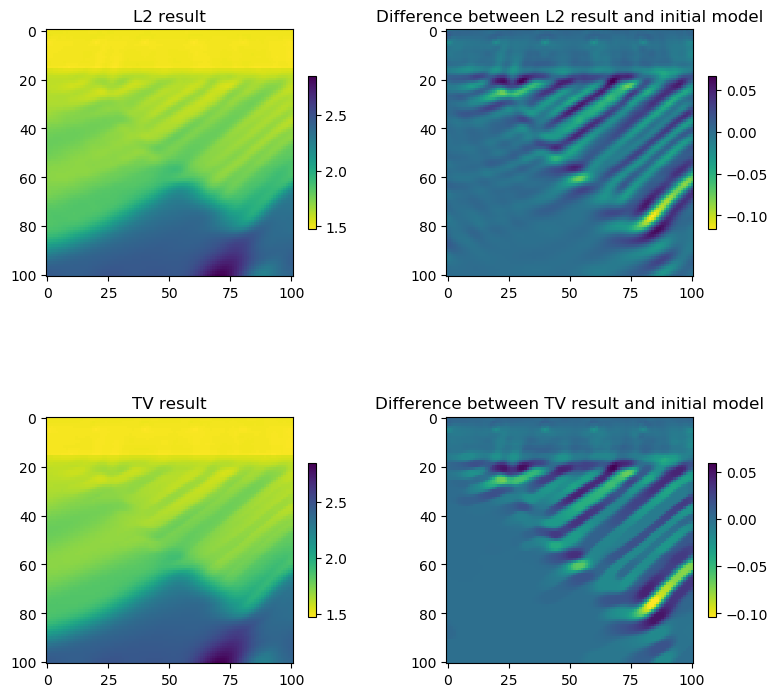

In [13]:
# show results
figure(figsize=(8,8))

subplot(221)
imshow(reshape(xk_l2,Nx,Ny), cmap="viridis_r"); colorbar(shrink=0.4)
title("L2 result")
subplot(222)
imshow(reshape(xk_l2,Nx,Ny)-c, cmap="viridis_r"); colorbar(shrink=0.4)
title("Difference between L2 result and initial model")

subplot(223)
imshow(reshape(xk_tv,Nx,Ny), cmap="viridis_r"); colorbar(shrink=0.4)
title("TV result")
subplot(224)
imshow(reshape(xk_tv,Nx,Ny)-c, cmap="viridis_r"); colorbar(shrink=0.4)
title("Difference between TV result and initial model")

tight_layout();

## Conclusion:

- TV regularization indeed makes some different and generates some strip-like structure in the inverse result.
- The TV gradient we used above is the right hand side of $DF^*(u)DF(u) \delta u = - \nabla_u f(y(u),u) - \lambda w$. Here we generate the descent step by replacing the normal operator $DF^*(u)DF(u)$ by identity operator $I$. That makes the optimization very slow.
- Need to change the model since the direct wave makes most of the contribution in the gradient (the top part of the gradient has large energy).
- Similar behavior with respect to our previous Curvelet work. More examples is needed.